In [1]:
import torch
import torchvision
print(torch.__version__)
print(torchvision.__version__)

2.4.1+cu121
0.19.1+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print('info: couldnt find torch info installing it')
  !pip install torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import datasetup,engine
  from helper_functions import download_data,set_seeds, plot_loss_curves
except:
  print('info: couldnt find the helper functions downloading them')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves


info: couldnt find the helper functions downloading them
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4356, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 4356 (delta 154), reused 119 (delta 119), pack-reused 4171 (from 3)
Receiving objects: 100% (4356/4356), 654.37 MiB | 42.63 MiB/s, done.
Resolving deltas: 100% (2583/2583), done.
Updating files: 100% (248/248), done.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
image_path = download_data(source = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination = "pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [5]:
train_dir = image_path/'train'
test_dir = image_path/'test'

Create Datasets and DataLoaders

In [11]:
len(list(train_dir.glob('pizza/*.jpg')))

78

In [6]:
IMAGE_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
]
)
print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


Turn images to Dataloaders


In [7]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir = train_dir,
    test_dir = test_dir,
    transform = manual_transforms,
    batch_size = BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7ee1c356ff10>,
 ['pizza', 'steak', 'sushi'])

Visualize a Single Image

In [8]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [9]:
image_batch, label_batch = next(iter(train_dataloader))
image = image_batch[0]
label = label_batch[0]



In [10]:
print(image.shape)
per_image = image.permute(1,2,0)
print(per_image.shape)

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])


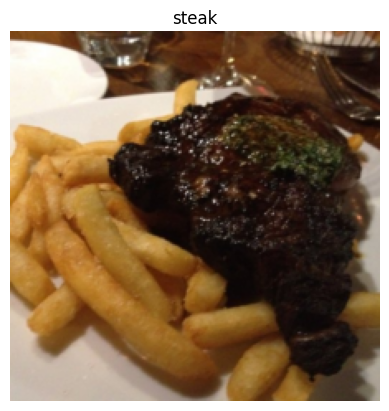

In [11]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis('off');


Calculate path embedding input and output shapes

In [12]:
height = 224
width = 224
color_channels = 3
patch_size = 16

number_of_patches = (height*width)//(patch_size*patch_size)
print(f'number of patches:{number_of_patches}, height and width of patch:{patch_size}')

number of patches:196, height and width of patch:16


In [13]:
embedding_layer_input_shape = (height,width,color_channels)
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f'Input shape (single 2D image): {embedding_layer_input_shape}')
print(f'Output shape (single 2D flattened into patches):{embedding_layer_output_shape}')



Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D flattened into patches):(196, 768)


Turning Single image into patches

In [14]:
per_image.shape

torch.Size([224, 224, 3])

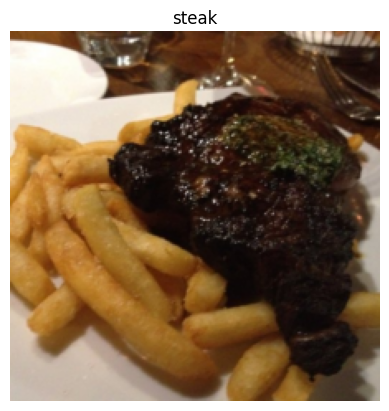

In [15]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

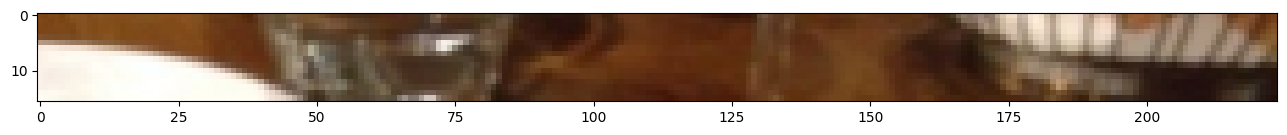

In [16]:
patch_size = 16
plt.figure(figsize = (patch_size,patch_size))
plt.imshow(per_image[:patch_size,:,:]);

Number of patches per row :14.0: patch dim:16


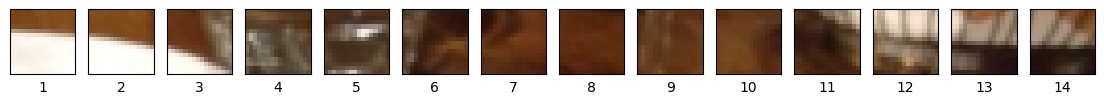

In [17]:
img_size = 224
patch_size =16
num_patches = img_size/patch_size
assert img_size%patch_size ==0, "image must be divisiblbe by patch size"
print(f"Number of patches per row :{num_patches}: patch dim:{patch_size}")

fig,axs = plt.subplots(nrows = 1,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )

for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(per_image[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])


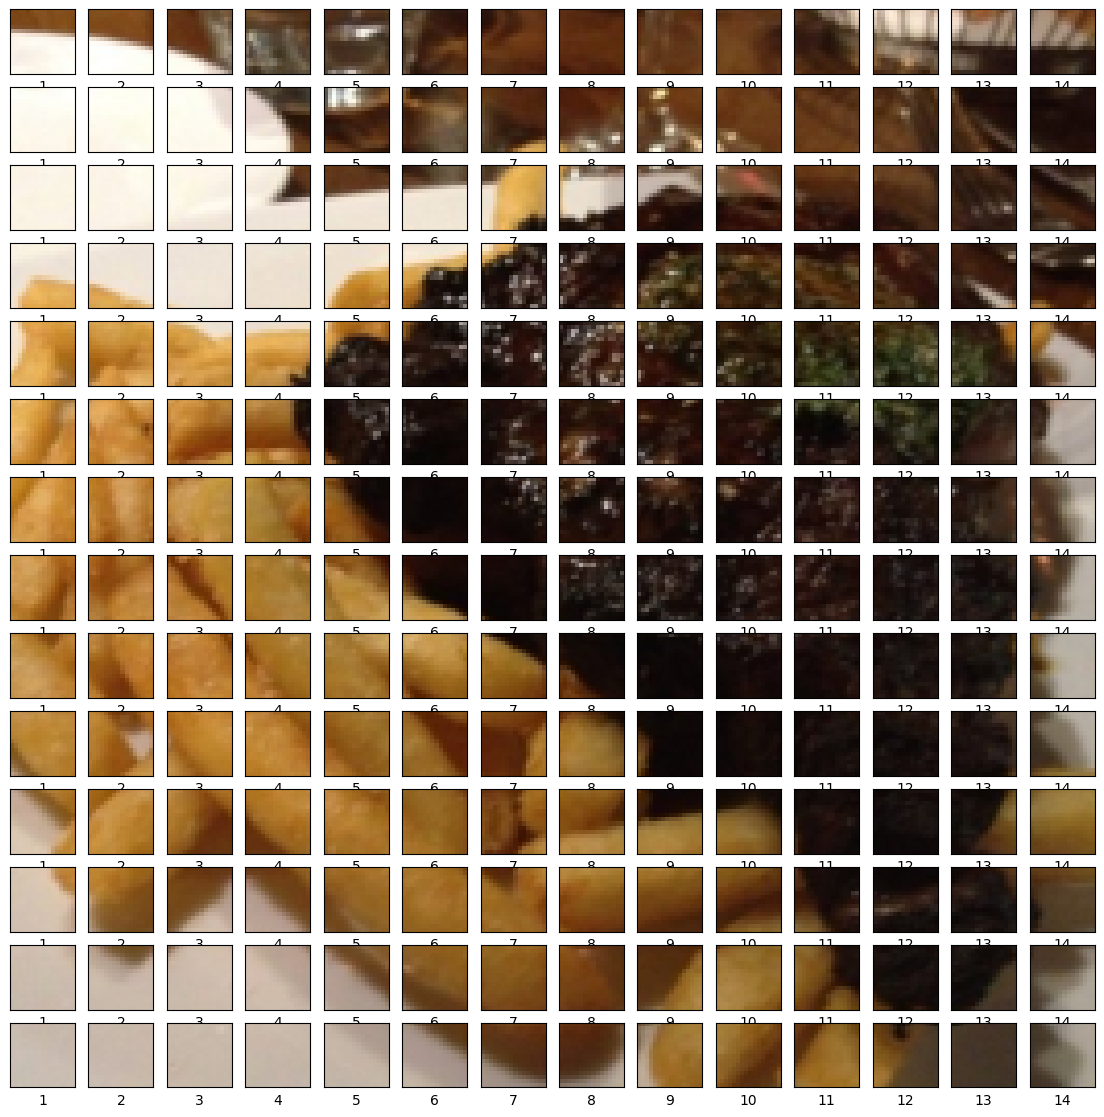

In [18]:
num_rows = img_size//patch_size
fig,axs = plt.subplots(nrows = num_rows,
                       ncols = img_size//patch_size,
                       figsize = (num_patches,num_patches),
                       sharex = True,
                       sharey = True
                       )
for j,patch_height in enumerate(range(0,img_size,patch_size)):
  for i, patch in enumerate(range(0,img_size,patch_size)):
    axs[j,i].imshow(per_image[patch_height:patch_height+patch_size,patch:patch+patch_size,:]);
    axs[j,i].set_xlabel(i+1)
    axs[j,i].set_xticks([])
    axs[j,i].set_yticks([])

Creating iamge patches using torch.Conv2d()

In [19]:
from torch import nn
patch_size = 16

conv2d = nn.Conv2d(
    in_channels = 3,
    out_channels = 768,
    stride = patch_size,
    kernel_size = patch_size
)

In [20]:
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

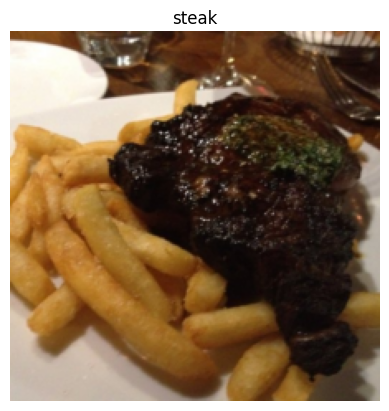

In [21]:
plt.imshow(per_image)
plt.title(class_names[label])
plt.axis(False);

In [22]:
print(image.shape)
image_out_of_conv = conv2d(image.unsqueeze(dim = 0))
print(image_out_of_conv.shape)

torch.Size([3, 224, 224])
torch.Size([1, 768, 14, 14])


showing random conv feature maps of indexes:[695, 434, 27, 426, 620]


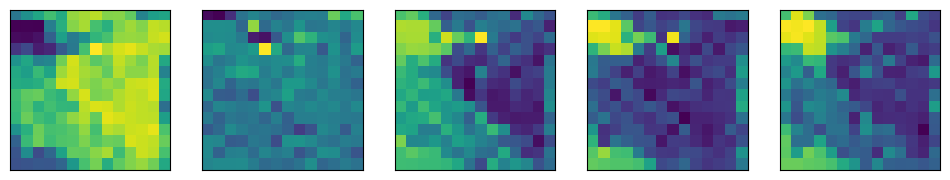

In [23]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

showing random conv feature maps of indexes:[398, 406, 17, 45, 314]


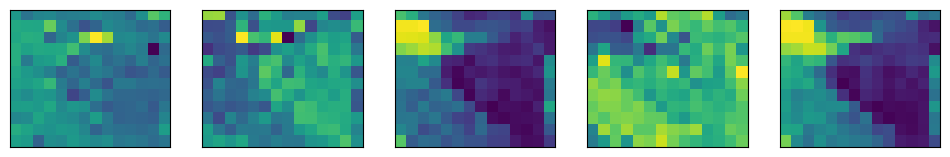

In [24]:
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random conv feature maps of indexes:{random_indexes}')

fig,axs = plt.subplots(nrows = 1,ncols = 5, figsize=(12,12))

for i,idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:,idx,:12,:]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels = [], yticklabels = [],xticks = [],yticks = []);

In [25]:
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map.shape,single_feature_map.requires_grad

(torch.Size([1, 14, 14]), True)

Flattening the path embedding with torch.nn.Flatten()

In [26]:
print(f'current tensor shape :{image_out_of_conv.shape}')

current tensor shape :torch.Size([1, 768, 14, 14])


In [27]:
flatten = nn.Flatten(start_dim =2,
                     end_dim = 3)

Original image shape:torch.Size([3, 224, 224])
image shape after conv is torch.Size([1, 768, 14, 14])
image after faltten is torch.Size([1, 768, 196])


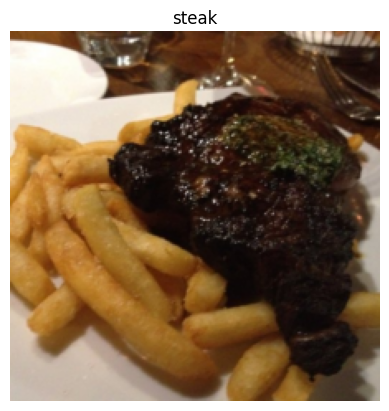

In [28]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);
print(f'Original image shape:{image.shape}')

image_out_of_conv = conv2d(image.unsqueeze(0))
print(f'image shape after conv is {image_out_of_conv.shape}')

image_flattened = flatten(image_out_of_conv)
print(f'image after faltten is {image_flattened.shape}')

In [29]:
image_out_of_conv_flattened_reshaped = image_flattened.permute(0,2,1)
print(f'Patch embedding sequence shape:{image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]')

Patch embedding sequence shape:torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


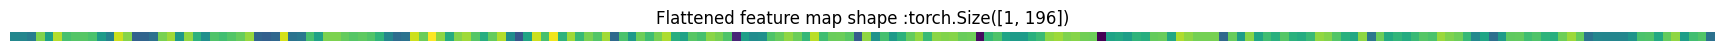

In [30]:
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:,:,0]

plt.figure(figsize = (22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape :{single_flattened_feature_map.shape}')
plt.axis(False);

Turning the VIT patch embedding layer into Pytorch module

In [31]:
class PatchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.in_channels = 3
    self.patch_size = 16
    self.embedding_dim = 768
    self.conv2d = nn.Conv2d(
        in_channels = self.in_channels,
        out_channels = self.embedding_dim,
        kernel_size = self.patch_size,
        stride = self.patch_size
    )
    self.flatten = nn.Flatten(start_dim = 2,
                              end_dim = 3)
  def forward(self,x):
    assert x.shape[-1] % self.patch_size == 0, f'Input size must be divisibel by patch size image:{x.shape} and patch:{self.patch_size}'
    x = self.conv2d(x)
    # print(x.shape)

    x = self.flatten(x)
    return x.permute(0,2,1)


In [32]:
embedding = PatchEmbedding()
flatten_output = embedding(image.unsqueeze(0))
print(flatten_output.shape)

torch.Size([1, 196, 768])


In [33]:
random_input_image = (1,3,224,224)
summary(PatchEmbedding(),
        input_size = random_input_image,
        col_names =["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=['var_names'] )



Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (conv2d)                        [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

Creating the class tokens embedding

In [34]:
print(flatten_output)
print(f'Patch embedding shape: {flatten_output.shape} -> [batch_size, number_of_patches, embedding_dimension]')

tensor([[[ 2.2622e-01,  1.6064e-01, -4.2979e-01,  ...,  7.5126e-01,
          -6.1265e-01, -3.2647e-02],
         [ 1.9512e-01, -4.7697e-05, -2.2114e-01,  ...,  7.5405e-01,
          -6.0712e-01, -2.5521e-01],
         [ 9.3794e-03, -5.8021e-02, -6.4133e-02,  ...,  7.1759e-01,
          -4.2935e-01,  7.2065e-02],
         ...,
         [ 2.2554e-01, -1.2446e-01, -1.0992e-01,  ...,  2.2135e-01,
          -3.6890e-01, -1.1902e-01],
         [ 8.1423e-02,  4.3628e-03, -1.1922e-01,  ...,  1.6358e-01,
          -2.3636e-01, -6.4832e-02],
         [ 1.1764e-01,  2.0902e-01, -2.9206e-01,  ...,  1.7116e-01,
          -2.7718e-01, -3.6112e-02]]], grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [35]:
batch_size = flatten_output.shape[0]
embedding_dimension = flatten_output.shape[-1]

class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension),
    requires_grad = True
)

print(class_token[:,:,:10])
print(f'class token shape {class_token.shape} --> [batch_size, number of tokens, embedding dimension]')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
class token shape torch.Size([1, 1, 768]) --> [batch_size, number of tokens, embedding dimension]


In [36]:
embeddings_with_class_embedding = torch.cat((class_token, flatten_output),dim = 1)

print(embeddings_with_class_embedding)
print(f'Sequence of path embedding shape:{embeddings_with_class_embedding.shape} --> [batch_size, number_of_patchs, embedding_dimension]')

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 2.2622e-01,  1.6064e-01, -4.2979e-01,  ...,  7.5126e-01,
          -6.1265e-01, -3.2647e-02],
         [ 1.9512e-01, -4.7697e-05, -2.2114e-01,  ...,  7.5405e-01,
          -6.0712e-01, -2.5521e-01],
         ...,
         [ 2.2554e-01, -1.2446e-01, -1.0992e-01,  ...,  2.2135e-01,
          -3.6890e-01, -1.1902e-01],
         [ 8.1423e-02,  4.3628e-03, -1.1922e-01,  ...,  1.6358e-01,
          -2.3636e-01, -6.4832e-02],
         [ 1.1764e-01,  2.0902e-01, -2.9206e-01,  ...,  1.7116e-01,
          -2.7718e-01, -3.6112e-02]]], grad_fn=<CatBackward0>)
Sequence of path embedding shape:torch.Size([1, 197, 768]) --> [batch_size, number_of_patchs, embedding_dimension]


Creating positional Embeddings

In [37]:
number_of_patchs = int((height*width)/patch_size**2)

embedding_dimension = embeddings_with_class_embedding.shape[2]

positional_embedding = nn.Parameter(torch.ones(1,number_of_patchs+1,
                                               embedding_dimension),
                                    requires_grad = True)
print(positional_embedding[:,:10,:10])
print(f'the dimensiona are: {positional_embedding.shape}')

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
the dimensiona are: torch.Size([1, 197, 768])


In [38]:
# lets add them to the path embeddings
patch_and_positional_embeddings = embeddings_with_class_embedding + positional_embedding
print(patch_and_positional_embeddings)
print(f'Patch embeddings with position embeddings:{patch_and_positional_embeddings.shape}')

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2262, 1.1606, 0.5702,  ..., 1.7513, 0.3873, 0.9674],
         [1.1951, 1.0000, 0.7789,  ..., 1.7540, 0.3929, 0.7448],
         ...,
         [1.2255, 0.8755, 0.8901,  ..., 1.2214, 0.6311, 0.8810],
         [1.0814, 1.0044, 0.8808,  ..., 1.1636, 0.7636, 0.9352],
         [1.1176, 1.2090, 0.7079,  ..., 1.1712, 0.7228, 0.9639]]],
       grad_fn=<AddBackward0>)
Patch embeddings with position embeddings:torch.Size([1, 197, 768])


Putting all this together from image to embeddings

In [39]:
set_seeds()

patch_size = 16
print(f'image tensor shape:{image.shape}')
height, width = image.shape[1],image.shape[2]

x = image.unsqueeze(dim = 0)
print(f' the dimensions of image sending in :{x.shape}')
patch_flattened_image = embedding(x)
print(f'the output of patch_flattend_image:{patch_flattened_image.shape}')

batch_size = 1
embedding_dimension = patch_flattened_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size,1,embedding_dimension),
                           requires_grad = True)
print(f'class token embedding shape:{class_token.shape}')

patch_embedding_class_token = torch.cat((class_token,patch_flattened_image),dim = 1)
print(f'Patch embedding with class token shape {patch_embedding_class_token.shape}')

number_of_patches = int((height*width)/(patch_size**2))
position_embedding = nn.Parameter(torch.ones(batch_size,number_of_patches+1,embedding_dimension),
                                  requires_grad = True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape :{patch_and_position_embedding.shape}')


image tensor shape:torch.Size([3, 224, 224])
 the dimensions of image sending in :torch.Size([1, 3, 224, 224])
the output of patch_flattend_image:torch.Size([1, 196, 768])
class token embedding shape:torch.Size([1, 1, 768])
Patch embedding with class token shape torch.Size([1, 197, 768])
Patch and position embedding shape :torch.Size([1, 197, 768])


MultiHeaded self Attention and layer normalization

In [40]:
class MultiHeadedSelfAttention(nn.Module):
  def __init__(self,embedding_dim = embedding_dimension,num_heads = 12,
               dropout = 0,
               ):
    super().__init__()
    self.layer_norm = torch.nn.LayerNorm(normalized_shape = embedding_dim)
    self.multihead_attn = nn.MultiheadAttention(embed_dim = embedding_dim,
                                                num_heads = num_heads,
                                                dropout = dropout,
                                                batch_first = True)

  def forward(self,x):
    x = self.layer_norm(x)
    attn_output, attn_weights = self.multihead_attn(
        query = x,
        key = x,
        value = x,
        need_weights = False
    )
    return attn_output


In [41]:
self_attn = MultiHeadedSelfAttention()
attention_output = self_attn(patch_and_position_embedding)
print(f'the attention output shape:{attention_output.shape}')

the attention output shape:torch.Size([1, 197, 768])


In [42]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.2262, 1.1606, 0.5702,  ..., 1.7513, 0.3873, 0.9674],
         [1.1951, 1.0000, 0.7789,  ..., 1.7540, 0.3929, 0.7448],
         ...,
         [1.2255, 0.8755, 0.8901,  ..., 1.2214, 0.6311, 0.8810],
         [1.0814, 1.0044, 0.8808,  ..., 1.1636, 0.7636, 0.9352],
         [1.1176, 1.2090, 0.7079,  ..., 1.1712, 0.7228, 0.9639]]],
       grad_fn=<AddBackward0>)

In [43]:
attention_output

tensor([[[ 3.0458e-01, -2.3025e-03, -1.3279e-01,  ...,  5.1433e-01,
           6.1338e-02,  1.0920e-01],
         [ 3.0080e-01,  2.3017e-03, -1.2802e-01,  ...,  5.0622e-01,
           7.3802e-02,  1.0981e-01],
         [ 2.9860e-01,  4.9054e-03, -1.2962e-01,  ...,  5.0296e-01,
           7.1666e-02,  1.0951e-01],
         ...,
         [ 2.9668e-01,  9.2025e-04, -1.2221e-01,  ...,  5.0951e-01,
           6.3950e-02,  1.1274e-01],
         [ 3.0248e-01, -1.7488e-04, -1.2931e-01,  ...,  5.1088e-01,
           7.1409e-02,  1.1726e-01],
         [ 3.0595e-01, -5.5538e-03, -1.3063e-01,  ...,  5.0831e-01,
           7.8640e-02,  1.1595e-01]]], grad_fn=<TransposeBackward0>)

In [44]:
class MLPLayer(nn.Module):
  def __init__(self, n_dim = 768,
               hidden_layer = 3072,
               dropout = 0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape = n_dim)
    self.mlp = nn.Sequential(
        nn.Linear(in_features =n_dim,
                  out_features = hidden_layer),
        nn.GELU(),
        nn.Dropout(p = dropout),
        nn.Linear(in_features = hidden_layer,
                  out_features = n_dim),
        nn.Dropout(p=dropout),
    )

  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x


In [45]:
mlp_block = MLPLayer(n_dim = 768,
                     hidden_layer = 3072,
                     dropout = 0.1)

patched_image_through_mlp = mlp_block(attention_output)
print(f'input to mlp layer:{attention_output.shape}')
print(f'output from mlp layer:{patched_image_through_mlp.shape}')



input to mlp layer:torch.Size([1, 197, 768])
output from mlp layer:torch.Size([1, 197, 768])


In [46]:
attention_output


tensor([[[ 3.0458e-01, -2.3025e-03, -1.3279e-01,  ...,  5.1433e-01,
           6.1338e-02,  1.0920e-01],
         [ 3.0080e-01,  2.3017e-03, -1.2802e-01,  ...,  5.0622e-01,
           7.3802e-02,  1.0981e-01],
         [ 2.9860e-01,  4.9054e-03, -1.2962e-01,  ...,  5.0296e-01,
           7.1666e-02,  1.0951e-01],
         ...,
         [ 2.9668e-01,  9.2025e-04, -1.2221e-01,  ...,  5.0951e-01,
           6.3950e-02,  1.1274e-01],
         [ 3.0248e-01, -1.7488e-04, -1.2931e-01,  ...,  5.1088e-01,
           7.1409e-02,  1.1726e-01],
         [ 3.0595e-01, -5.5538e-03, -1.3063e-01,  ...,  5.0831e-01,
           7.8640e-02,  1.1595e-01]]], grad_fn=<TransposeBackward0>)

In [47]:
patched_image_through_mlp

tensor([[[ 0.3275,  0.0587, -0.1475,  ...,  0.0774,  0.1375, -0.0434],
         [ 0.3285,  0.0779, -0.1473,  ...,  0.0810,  0.1836, -0.1005],
         [ 0.3958,  0.0701, -0.1372,  ...,  0.0542,  0.0000,  0.0312],
         ...,
         [ 0.3541,  0.0742, -0.1777,  ...,  0.0706,  0.1860,  0.0527],
         [ 0.4018,  0.0062, -0.0000,  ..., -0.0085,  0.1836, -0.0020],
         [ 0.3621,  0.1046, -0.1175,  ...,  0.0849,  0.1853,  0.0153]]],
       grad_fn=<MulBackward0>)

We are going to create a transformer Encoder

In [48]:
class TransformerEncoder(nn.Module):
  def __init__(self,
               attention_block = MultiHeadedSelfAttention(),
               mlp_block = MLPLayer(n_dim = 768,
                     hidden_layer = 3072,
                     dropout = 0.1)):
    super().__init__()
    self.msa_block = attention_block
    self.mlp_block = mlp_block

  def forward(self,x):
    msa_output = self.msa_block(x)
    mlp_input = msa_output+x
    mlp_output = self.mlp_block(mlp_input)
    return mlp_output+mlp_input



In [49]:
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [50]:
encoder_block = TransformerEncoder()
encoder_output = encoder_block(patch_and_position_embedding)

In [51]:
encoder_output.shape

torch.Size([1, 197, 768])

In [52]:
encoder_output

tensor([[[1.7562, 2.0242, 1.6986,  ..., 3.1862, 2.3225, 2.3921],
         [1.2814, 1.2804, 0.1490,  ..., 2.9647, 0.5699, 1.1049],
         [1.1014, 1.1297, 0.4789,  ..., 3.1023, 0.6069, 0.9946],
         ...,
         [1.2252, 1.0479, 0.3157,  ..., 2.3637, 0.9858, 1.2160],
         [0.9283, 0.9659, 0.3807,  ..., 2.3736, 1.0973, 1.1045],
         [1.0110, 1.3607, 0.2699,  ..., 2.4166, 1.0034, 1.2276]]],
       grad_fn=<AddBackward0>)

In [53]:
# Get summary using Torch info.summary
summary(encoder_block,
        input_size = (1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoder (TransformerEncoder)            [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadedSelfAttention (msa_block)             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPLayer (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Creating Transformer using pytorch inbuilt functions

In [54]:
torch_transformer_encoder_layer  = nn.TransformerEncoderLayer(d_model = 768,
                                                              nhead = 12,
                                                              dim_feedforward = 3072,
                                                              dropout = 0.1,
                                                              activation = 'gelu',
                                                              batch_first = True,
                                                              norm_first = True)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [55]:
# Get summary using Torch info.summary
summary(torch_transformer_encoder_layer,
        input_size = (1,197,768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

Putting it all together to create VIT

In [56]:
class ViT(nn.Module):
  def __init__(self,
               img_size = 224,
               in_channels = 3,
               patch_size = 16,
               num_transformers_layers = 12,
               embedding_dim = 768,
               mlp_size = 3072,
               num_heads = 12,
               drop_out = 0.1,
               num_classes = 3):
    super().__init__()

    assert img_size & patch_size ==0,f'The image size:{img_size} doesnt div by patch_size:{patch_size}'

    self.patches = int((img_size*img_size)/(patch_size**2))

    self.class_embedding = nn.Parameter(data = torch.randn(1,1,embedding_dim),
                                        requires_grad= True)

    self.positional_embedding = nn.Parameter(data = torch.randn(1,self.patches+1,embedding_dim),
                                             requires_grad = True)

    self.embedding_dropout = nn.Dropout(p = drop_out)

    self.patch_embeddings = PatchEmbedding()

    self.transformer_encoder = nn.Sequential(*[TransformerEncoder() for _ in range(num_transformers_layers)])

    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape = embedding_dim),
        nn.Linear(in_features = embedding_dim,
                  out_features = num_classes))

  def forward(self,x):

      batch_size = x.shape[0]
      class_token = self.class_embedding.expand(batch_size, -1,-1)
      # print(f'class token:{class_token.shape}')
      patches = self.patch_embeddings(x)
      # print(f'patches:{patches.shape}')
      class_added = torch.cat((class_token,patches),dim = 1)
      pos_added = class_added + self.positional_embedding
      pos_added = self.embedding_dropout(pos_added)
      encoder_output = self.transformer_encoder(pos_added)
      x = encoder_output[:,0]
      # print(f'shape of transformer output is {x.shape}')
      class_logits = self.classifier(x)
      return class_logits

In [61]:
vit = ViT().to(device)
# vit

Get the summary

In [62]:
summary(
    model = vit,
    input_size = (32,3,224,224),
      col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embeddings)                          [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (conv2d)                                       [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoder (0)                                [32, 197, 768]       [32, 197, 768]

In [63]:
batch_size = 32
class_token_embedding_single = nn.Parameter(data = torch.randn(1,1,768))
class_token_expanded = class_token_embedding_single.expand(batch_size,-1,-1)

print(f'before expand:{class_token_embedding_single.shape}')
print(f'after expand:{class_token_expanded.shape}')

before expand:torch.Size([1, 1, 768])
after expand:torch.Size([32, 1, 768])


In [65]:
set_seeds()

random_image = torch.randn(1,3,224,224).to(device)
logits = vit(random_image)
print(logits)

tensor([[-0.3146,  0.2885, -0.3154]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


Training the model

# Creating Optimizers

optim = torch.optim.Adam(params = vit.parameters(),
                         lr = 1e-3,
                         betas = (0.9,0.999),
                         weight_decay = 0.3)

loss_fn = nn.CrossEntropyLoss()


from going_modular.going_modular import engine

results = engine.train(model = vit,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optim,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)

Transfer Learning

In [66]:
import torchvision

weights = torchvision.models.ViT_B_16_Weights.DEFAULT


In [67]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [68]:
image.shape

torch.Size([3, 224, 224])

In [69]:
model = torchvision.models.vit_b_16(weights = weights, progress= True)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 200MB/s] 


In [71]:
summary(model = model,
        input_size = (32,3,224,224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              True
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 76

In [72]:
for param in model.parameters():
  param.requires_grad = False


In [73]:
model.heads = nn.Sequential(
    nn.Linear(in_features = 768,
              out_features = 3,
              bias = True)
)

In [74]:
summary(model = model,
        input_size = (32,3,224,224),
         col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [75]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [78]:
train_dataloader, test_dataloader,num_classes = data_setup.create_dataloaders(train_dir = train_dir,
                                                                 test_dir = test_dir,
                                                                 transform = auto_transform,
                                                                 batch_size = 32)

In [79]:
model = model.to(device)

In [80]:
from timeit import default_timer as timer

start_timer = timer()

results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       optimizer = optimizer,
                       loss_fn = loss_fn,
                       epochs = 10,
                       device = device)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7623 | train_acc: 0.7539 | test_loss: 0.4986 | test_acc: 0.8371
Epoch: 2 | train_loss: 0.3278 | train_acc: 0.9453 | test_loss: 0.3403 | test_acc: 0.8778
Epoch: 3 | train_loss: 0.2051 | train_acc: 0.9609 | test_loss: 0.2452 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1723 | train_acc: 0.9688 | test_loss: 0.2179 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1406 | train_acc: 0.9766 | test_loss: 0.2142 | test_acc: 0.9186
Epoch: 6 | train_loss: 0.1085 | train_acc: 0.9766 | test_loss: 0.1979 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.1028 | train_acc: 0.9766 | test_loss: 0.1982 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.0861 | train_acc: 0.9805 | test_loss: 0.1935 | test_acc: 0.9280
Epoch: 9 | train_loss: 0.0769 | train_acc: 0.9805 | test_loss: 0.1996 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.0720 | train_acc: 0.9844 | test_loss: 0.2038 | test_acc: 0.8977


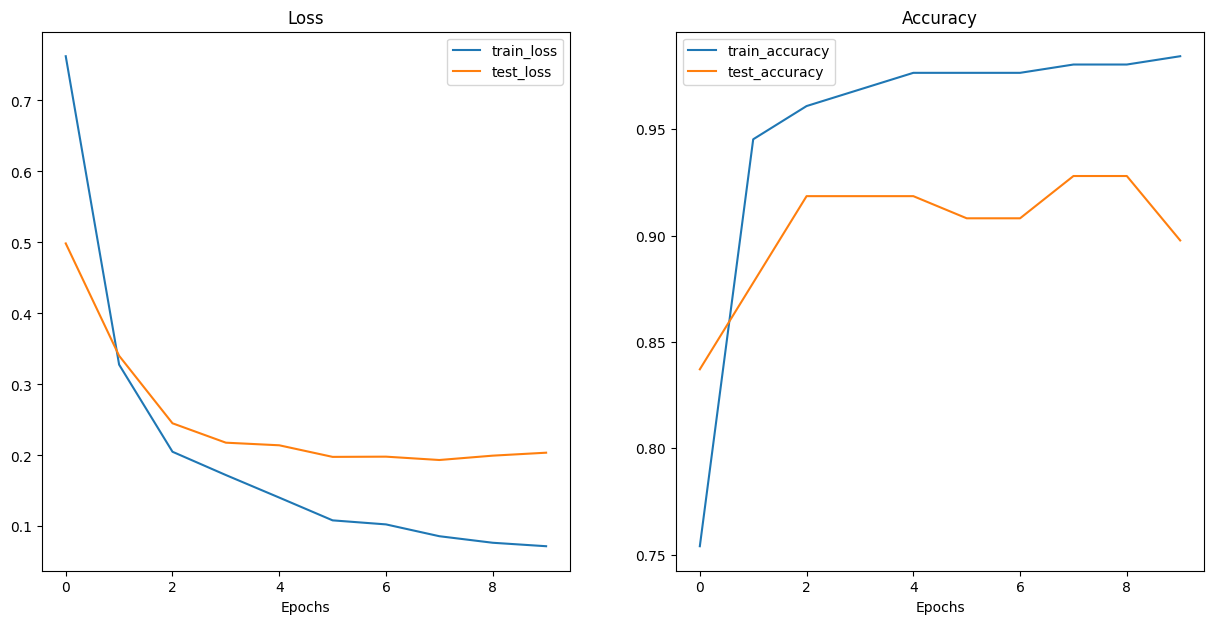

In [81]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

In [84]:
torch.save(model.state_dict(), 'finetuned_vit.pth')

In [87]:
from pathlib import Path
model_size = Path("/kaggle/working/finetuned_vit.pth").stat().st_size//(1024*1024)
print(f'the model size:{model_size}')


the model size:327
